### Scatterplot of SMRT median vs obs: all frequencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import ks_2samp
import xarray as xr

In [2]:
%load_ext autoreload
%aimport aesop
%autoreload 1

/home/mjs/.virtualenvs/aesop/lib/python3.8/site-packages/iris/config.py:84: UserWarning: Ignoring config item 'Resources':'test_data_dir' (section:option) as '/home/h05/itwl/projects/git/iris-test-data/test_data' is not a valid directory path.
  warnings.warn(msg.format(section, option, c_path))


Load observations:

In [3]:
obs_c087 = aesop.get_obs_per_aoi('C087')
obs_c090 = aesop.get_obs_per_aoi('C090')

/home/mjs/.virtualenvs/aesop/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/mjs/.virtualenvs/aesop/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/mjs/.virtualenvs/aesop/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making 

Load SMRT results without atmosphere:

In [4]:
smrt_no_atmos = xr.open_dataset('../Other/smrt_results_atmos/smrt_tb_no_atmosphere.nc')

Load SMRT results with atmosphere:

In [5]:
smrt_c087 = xr.open_dataset('../Other/smrt_results_atmos/smrt_atmos_tb_C087.nc')
smrt_c090 = xr.open_dataset('../Other/smrt_results_atmos/smrt_atmos_tb_C090.nc')

Load pits with topography:

In [6]:
pits = aesop.get_pit_topography()

In [7]:
ch_list = ['M16-89', '118+5.0', 'M17-157', 'M20-183+7', '243']
obs_medians = [np.quantile(obs_c087[channel].dropna().TB.values, 0.5) for channel in ch_list] + [np.quantile(obs_c090[channel].dropna().TB.values, 0.5) for channel in ch_list]
smrt_no_atmos_medians = [np.quantile(smrt_no_atmos['base'].sel(channel=channel),0.5) for channel in ch_list] * 2
smrt_with_atmos = [np.quantile(smrt_c087['base'].sel(channel=channel),0.5) for channel in ch_list] + [np.nanquantile(smrt_c090['base'].sel(channel=channel),0.5) for channel in ch_list]  

Text(0, 0.5, 'Simulated TB (K)')

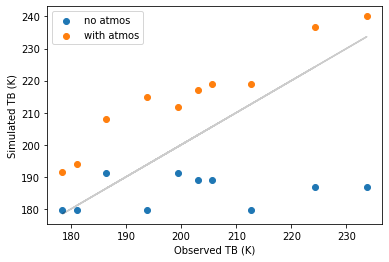

In [8]:
plt.close()
plt.scatter(obs_medians, smrt_no_atmos_medians, label='no atmos')
plt.scatter(obs_medians, smrt_with_atmos, label='with atmos')
plt.plot(obs_medians, obs_medians, 'k-', alpha=0.2)
plt.legend()
plt.xlabel('Observed TB (K)')
plt.ylabel('Simulated TB (K)')

In [9]:
# RMSE
print (np.sqrt(np.nanmean((np.asarray(obs_medians) - np.asarray(smrt_no_atmos_medians))**2)))
print (np.sqrt(np.nanmean((np.asarray(obs_medians) - np.asarray(smrt_with_atmos))**2)))

23.33769306227544
14.153606705333388


Calc RMSE considering SMRT simulations vs topography type in AOI

In [13]:
# Single flight - C087
#obs = obs_c087
#smrt = smrt_c087
obs = obs_c090
smrt = smrt_c090
tb_obs = []
smrt_tb = []
smrt_tb_noatmos = []

pit_order = smrt_c087.snowpack.values

channels = ['M16-89','118+5.0','M17-157','M20-183+7','243']

for channel in channels:
    for p in pit_order:
            topo = pits.loc[p].topo_type
            p = 'A04' if p == 'MetS' else p

            tb_obs.append(np.nanmedian(obs.loc[p[:3]][channel][obs.loc[p[:3]][channel].topo_type==topo].TB))

    smrt_tb.append(smrt.sel(channel=channel)['base'].values)
    smrt_tb_noatmos.append(smrt_no_atmos.sel(channel=channel)['base'].values)

# SMRT into single array rather than list of arrays by frequency
smrt_tb = np.concatenate(smrt_tb).ravel().tolist()
smrt_tb_noatmos = np.concatenate(smrt_tb_noatmos).ravel().tolist()

Text(0, 0.5, 'Simulated TB (K)')

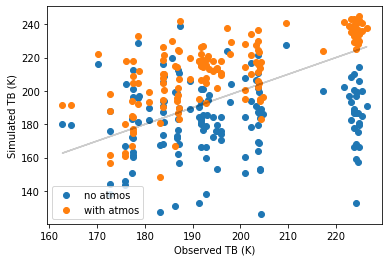

In [14]:
plt.close()
plt.scatter(tb_obs, smrt_tb_noatmos, label='no atmos')
plt.scatter(tb_obs, smrt_tb, label='with atmos')
plt.plot(tb_obs, tb_obs, 'k-', alpha=0.2)
plt.legend()
plt.xlabel('Observed TB (K)')
plt.ylabel('Simulated TB (K)')

In [16]:
# RMSE - individual pits by topo type for one flight
print (np.sqrt(np.nanmean((np.asarray(tb_obs) - np.asarray(smrt_tb_noatmos))**2)))
print (np.sqrt(np.nanmean((np.asarray(tb_obs) - np.asarray(smrt_tb))**2)))
print (len(smrt_tb))

29.186598045833005
21.672240794538837
145


In [ ]:
# Distribution statistics
def get_dist_stats(channel):
    tb_all = obs_c087[channel].dropna().TB.values # Unhash these lines to only use data for C087.
    smrt_all = np.concatenate((smrt_c087['base'].sel(channel=channel), smrt_c087['high'].sel(channel=channel), smrt_c087['low'].sel(channel=channel)))
    smrt_noatmos = np.concatenate((smrt_no_atmos['base'].sel(channel=channel), smrt_no_atmos['high'].sel(channel=channel), smrt_no_atmos['low'].sel(channel=channel)))
    print('Obs mean: ', np.round(np.nanmean(tb_all),1), 'Obs median: ', np.round(np.nanquantile(tb_all, 0.5),1), 'Obs spread: ', np.round(np.max(tb_all) - np.min(tb_all),1))
    print('SMRT mean: ', np.round(np.nanmean(smrt_noatmos),1), 'SMRT median: ', np.round(np.nanquantile(smrt_noatmos, 0.5),1), 'SMRT spread: ', np.round(np.max(smrt_noatmos) - np.min(smrt_noatmos),1))
    print('SMRT+atmos mean: ', np.round(np.nanmean(smrt_all),1), 'SMRT+atmos median: ', np.round(np.nanquantile(smrt_all, 0.5),1), 'SMRT+atmos spread: ', np.round(np.max(smrt_all) - np.min(smrt_all),1))
    
    # Kolmogorov-Smirnov 2 sample test
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
    print ('SMRT vs Obs K-S test', ks_2samp(tb_all, smrt_noatmos))
    print ('SMRT+atmos vs Obs K-S test', ks_2samp(tb_all, smrt_all))

In [ ]:
# Channels: ['M16-89', '118+5.0', 'M17-157', 'M20-183+7', '243']
# Null hypothesis: from same distribution
# Reject null hypothesis if p-value < e.g. 0.05 for 5% level (95% confidence)
get_dist_stats('M16-89')

In [ ]:
get_dist_stats('118+5.0')

In [ ]:
get_dist_stats('M17-157')

In [ ]:
get_dist_stats('M20-183+7')

In [ ]:
get_dist_stats('243')

In [ ]:
# Check KS use by taking from same population
tb_all = obs_c087['M16-89'].dropna().TB.values
tb_some = np.random.choice(tb_all, 5)
ks_2samp(tb_all, tb_some)